In [1]:
#Adding last modified date
from datetime import datetime
from IPython.display import display, Markdown
todays_date = str(datetime.now().date())
time = str(str(datetime.now().time()))
author = "Keerthana Arun"
display(Markdown(f'Last modified on {todays_date} at {time} by {author}'))

Last modified on 2025-02-12 at 14:09:32.591218 by Keerthana Arun

# Solving ODEs deterministically using same paramters to compare average values of Gillespie simulations at steady state

### Setting up the reactions for toy model: g-1 -> g0

In [9]:
import pandas as pd
from sympy import symbols, Function, Eq, diff, solve, sympify

# Load the reaction data from a CSV file
data = pd.read_csv('/home/mzo5929/Keerthana/GRNsimulation/highthroughputData/linearNetworksSimulationSetup/moreLinearNetworkSimulationSetup/graph17/reactions/reactions.csv')

# Load parameter values from another CSV file
param_data = pd.read_csv('/home/mzo5929/Keerthana/GRNsimulation/highthroughputData/parameterSets/singleParameter_1188.csv')

In [11]:
import pandas as pd
from sympy import symbols, Function, Eq, diff, solve, sympify

# Load the CSV file
parameters = {}
# Define time variable
t = symbols('t')

# Preprocess names to replace '-' with '_'
data['species1'] = data['species1'].str.replace('-', '_').str.strip()
data['species2'] = data['species2'].str.replace('-', '_').str.strip()

# Create unique species symbols
species_names = set(data['species1'].dropna().unique()).union(data['species2'].dropna().unique())
species_names = [sp for sp in species_names if sp and sp != '_']  # Filter out invalid names
species = {sp: Function(sp)(t) for sp in species_names}

# Initialize differential equations with zero
odes = {species[sp]: 0 for sp in species_names}

# Initialize parameters set
params = set()

# Parse each reaction and construct the differential equations
for index, row in data.iterrows():
    reactant = species.get(row['species1'])
    product = species.get(row['species2'])
    propensity_expr = row['propensity'].replace('{', '').replace('}', '').replace('-', '_')
    rate_expr = sympify(propensity_expr, locals={**species, **{str(p): p for p in params}})

    # Update the parameter set with new symbols found in the rate expression
    params.update(rate_expr.free_symbols - set(species.values()))

    # Update the ODEs for reactants and products
    if reactant:
        reactant_change = int(row['change1'])
        odes[reactant] += reactant_change * rate_expr if reactant_change else -rate_expr
    if product:
        product_change = int(row['change2'])
        odes[product] += product_change * rate_expr if product_change else +rate_expr

# Load and substitute parameter values
for index, row in param_data.iterrows():
    value = sympify(row['value'].replace('{', '').replace('}', ''), locals=parameters)
    parameters[row['parameter']] = value

# Substitute parameters into the ODEs
for sp in species:
    odes[sp] = odes[sp].subs(parameters)

# Convert dictionary of ODEs to a list of equations for steady state
ode_equations = [Eq(diff(sp, t), rate) for sp, rate in odes.items()]
steady_state_equations = [eq.subs(diff(sp, t), 0) for sp, eq in odes.items()]

# Solve for steady states
steady_state_solutions = solve(steady_state_equations, list(species.values()))

# Display the solutions
print("Steady State Solutions:")
print(steady_state_solutions)

# Display the parameters for user reference
print("Parameters:", parameters)

KeyError: 'g10_I'

## Solving for steady state solutions

In [12]:
parameters = {}

# Define the time variable
t = symbols('t')

# Create species functions, ensuring no underscores are in the final keys
data['species1'] = data['species1'].str.replace('-', '_').str.strip()
data['species2'] = data['species2'].str.replace('-', '_').str.strip()
species_names = set(data['species1'].dropna().unique()).union(data['species2'].dropna().unique())
species = {sp: Function(sp)(t) for sp in species_names if sp != '_'}

# Initialize differential equations with zero
odes = {species[sp]: 0 for sp in species}

# Load and evaluate parameters, handling dependencies
for index, row in param_data.iterrows():
    value = sympify(row['value'].replace('{', '').replace('}', ''), locals=parameters)
    parameters[row['parameter']] = value

# Resolving dependencies in parameter values
for param, value in parameters.items():
    if isinstance(value, str):
        parameters[param] = sympify(value, locals=parameters)

# Construct the ODEs using the updated parameters
for index, row in data.iterrows():
    reactant = species.get(row['species1'])
    product = species.get(row['species2'])
    rate_expr = sympify(row['propensity'].replace('{', '').replace('}', '').replace('-', '_'), locals={**species, **parameters})

    if reactant:
        reactant_change = int(row['change1'])
        odes[reactant] += reactant_change * rate_expr if reactant_change else -rate_expr
    if product:
        product_change = int(row['change2'])
        odes[product] += product_change * rate_expr if product_change else +rate_expr
# Substitute parameters into ODEs
for sp, expr in odes.items():
    odes[sp] = expr.subs(parameters)

# Add constraints directly to the equations
constraints = []
for gene_prefix in {'g0', 'g_1'}:
    active = species[f'{gene_prefix}_A']
    inactive = species[f'{gene_prefix}_I']
    # Creating constraint equations
    constraint = Eq(active + inactive, 1)
    constraints.append(constraint)

# Separate equations by species group
g1_equations = [eq for sp, eq in odes.items() if 'g_1' in str(sp)] + [c for c in constraints if 'g_1' in str(c)]
g0_equations = [eq for sp, eq in odes.items() if 'g0' in str(sp)] + [c for c in constraints if 'g0' in str(c)]

# Solve g1 equations first
g1_solutions = solve(g1_equations, [species[sp] for sp in species if 'g_1' in sp], dict=True)

# Substitute g1 solutions into g0 equations
g0_equations_substituted = [eq.subs(g1_solutions[0]) for eq in g0_equations]

# Now solve the g0 equations with the substitutions
g0_solutions = solve(g0_equations_substituted, [species[sp] for sp in species if 'g0' in sp], dict=True)

# Combine solutions
solutions = {**g1_solutions[0], **g0_solutions[0]}

KeyError: 'g_1_A'

### More automated hopefully

In [13]:
from sympy import symbols, Function, Eq, solve, diff, sympify
import pandas as pd

# Define the time variable
t = symbols('t')

# Load your data
# data = pd.read_csv('path_to_data.csv')
# param_data = pd.read_csv('path_to_param_data.csv')

# Prepare species and parameter dictionaries
species_names = set(data['species1'].dropna().unique()).union(data['species2'].dropna().unique())
species_names = [sp for sp in species_names if sp and sp != '_']  # Filter out invalid names
species = {sp.replace('-', '_'): Function(sp.replace('-', '_'))(t) for sp in species_names}
parameters = {row['parameter']: sympify(row['value'].replace('{', '').replace('}', ''), locals=parameters) 
              for index, row in param_data.iterrows()}

# Evaluate and substitute dependencies in parameters
for param, value in parameters.items():
    parameters[param] = sympify(value, locals=parameters).subs(parameters)

# Initialize ODEs with zero
odes = {sp: 0 for sp in species.values()}

# Build ODEs from data, adding error handling
for index, row in data.iterrows():
    reactant = species.get(row['species1'].replace('-', '_'))
    product = species.get(row['species2'].replace('-', '_'))
    rate_expr = sympify(row['propensity'].replace('{', '').replace('}', '').replace('-', '_'), locals={**species, **parameters})

    # Safely convert changes to integers
    try:
        reactant_change = int(row['change1']) if row['change1'] != '-' else 0
    except ValueError:
        raise ValueError("ERROR IN STEP 1") # Default to 0 or log error

    try:
        product_change = int(row['change2']) if row['change2'] != '-' else 0
    except ValueError:
        raise ValueError("ERROR IN STEP 2") # Default to 0 or log error

    # Update ODEs
    if reactant:
        odes[reactant] += rate_expr * reactant_change
    if product:
        odes[product] += rate_expr * product_change

# Add constraints for gene activation states
print(species_names)
# Extract unique gene prefixes to avoid duplicate constraints
gene_prefixes = set('_'.join(g.split('_')[:-1]) for g in species_names if '_' in g)

# Generate unique constraints for each gene prefix
constraints = [Eq(species[gene_prefix + '_A'] + species[gene_prefix + '_I'], 1) for gene_prefix in gene_prefixes]

['g10_I', 'g4_A', 'g7_A', 'g6_A', 'g9_A', 'g5_I', 'g17_mRNA', 'g1_A', 'g15_I', 'g1_mRNA', 'g6_I', 'g8_I', 'g2_A', 'g14_I', 'g12_A', 'g15_mRNA', 'g13_mRNA', 'g16_mRNA', 'g5_A', 'g16_A', 'g11_I', 'g12_mRNA', 'g2_I', 'g7_mRNA', 'g2_mRNA', 'g13_A', 'g6_mRNA', 'g16_I', 'g11_A', 'g1_I', 'g11_mRNA', 'g9_mRNA', 'g7_I', 'g12_I', 'g8_A', 'g3_I', 'g14_A', 'g10_A', 'g10_mRNA', 'g9_I', 'g3_mRNA', 'g14_mRNA', 'g15_A', 'g4_mRNA', 'g8_mRNA', 'g17_I', 'g17_A', 'g3_A', 'g4_I', 'g5_mRNA', 'g13_I']


Identifying the order to solve the equations based on the topology - currently, only for DAG

In [14]:
import networkx as nx

# Load the graph from a GML file
gml_path = '/home/mzo5929/Keerthana/GRNsimulation/highthroughputData/linearNetworksSimulationSetup/moreLinearNetworkSimulationSetup/graph17/networks/graph17.gml'
dependency_graph = nx.read_gml(gml_path)
# Perform topological sort to find the solving order
relabel_mapping = {node: node.replace('-', '_') for node in dependency_graph.nodes()}
dependency_graph = nx.relabel_nodes(dependency_graph, relabel_mapping)
try:
    solving_order = list(nx.topological_sort(dependency_graph))
    print("Solving order based on dependencies:", solving_order)
except nx.NetworkXUnfeasible:
    print("Error: The dependency graph has cycles, which means it's not a DAG.")

Solving order based on dependencies: ['g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8', 'g9', 'g10', 'g11', 'g12', 'g13', 'g14', 'g15', 'g16', 'g17']


In [15]:
all_solutions = {}
for group in solving_order:
    # Filter equations and species for the current group
    current_group_equations = [eq for sp, eq in odes.items() if group in str(sp)] + [c for c in constraints if group in str(c)]
    current_group_species = [species[sp] for sp in species if group in sp]
    # print(current_group_equations)
    # Solve equations for the current group
    group_solutions = solve(current_group_equations, current_group_species, dict=True)
    if group_solutions:
        all_solutions.update(group_solutions[0])

    # Update equations for all subsequent groups by substituting solutions found
    for subsequent_group in solving_order[solving_order.index(group) + 1:]:
        for sp, eq in odes.items():
            if subsequent_group in str(sp):
                odes[sp] = eq.subs(group_solutions[0])

# Now, all equations should be solved, and `all_solutions` should contain the answers
print("All solutions:", all_solutions)

KeyboardInterrupt: 

In [87]:
constraints

[Eq(g0_A(t) + g0_I(t), 1), Eq(g_1_A(t) + g_1_I(t), 1)]

In [ ]:
{'g-1_A': 0.0094864,
 'g-1_I': 0.9905136,
 'g-1_mRNA': 14.7277444,
 'g0_A': 0.025142,
 'g0_I': 0.974858,
 'g0_mRNA': 22.2995648}

## Now, numerically solving it using IVP_solver (equivalent of ODE45 in matlab)

In [16]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
import re

# Load reactions
reactions_df = pd.read_csv('/home/mzo5929/Keerthana/GRNsimulation/highthroughputData/linearNetworksSimulationSetup/moreLinearNetworkSimulationSetup/graph17/reactions/reactions.csv')

# Load parameters
params_df = pd.read_csv('/home/mzo5929/Keerthana/GRNsimulation/highthroughputData/parameterSets/singleParameter_1188.csv')
params = params_df.set_index('parameter')['value'].to_dict()

initial_conditions_df = pd.read_csv('/home/mzo5929/Keerthana/GRNsimulation/highthroughputData/linearNetworksSimulationSetup/moreLinearNetworkSimulationSetup/graph17/initialStates.csv')

In [17]:
params

{'rProd': '0.882593485',
 'rDeg': '0.008826497',
 'rOn': '0.001204947',
 'rOff': '0.073818167',
 'd': '51.18867299',
 'rAdd': '0.698330981',
 'n': '0.164639947',
 'k': ' (0.5 * {d} * ({rProd}/{rDeg}))'}

In [18]:
# Normalize species names in the reactions DataFrame
def normalize_species_name(name):
    return name.replace("-", "_")

reactions_df['species1'] = reactions_df['species1'].apply(normalize_species_name)
reactions_df['species2'] = reactions_df['species2'].apply(normalize_species_name)
reactions_df['propensity'] = reactions_df['propensity'].apply(normalize_species_name)

# Update propensities in the DataFrame using updated parameter values
def update_propensities(reactions_df, params):
    for param, value in params.items():
        if isinstance(value, str):
            value = eval(value.format(**params))
        reactions_df['propensity'] = reactions_df['propensity'].replace(f"{{{param}}}", str(value), regex=True)
    return reactions_df

reactions_df = update_propensities(reactions_df, params)

# Parse reactions to create ODE system
def parse_reactions(reactions_df):
    species = set(reactions_df['species1'].tolist() + reactions_df['species2'].tolist())
    species.discard('_')  # Remove placeholder if used
    print(species)
    def ode_system(t, y):
        dydt = {s: 0 for s in species}
        species_idx = {s: i for i, s in enumerate(species)}
        for idx, row in reactions_df.iterrows():
            local_env = {s: y[species_idx[s]] for s in species}
            reaction_rate = eval(row['propensity'], None, local_env)

            # Convert changes to float, handle both '_' and '-' placeholders
            change1 = float(row['change1']) if row['change1'] not in ('_', '-') else 0
            change2 = float(row['change2']) if row['change2'] not in ('_', '-') else 0

            if row['species1'] not in ('_', '-'):
                dydt[row['species1']] += reaction_rate * change1
            if row['species2'] not in ('_', '-'):
                dydt[row['species2']] += reaction_rate * change2

        return [dydt[s] for s in species]
    return ode_system, list(species)
ode_system, species_list = parse_reactions(reactions_df)

# Load initial conditions and setup

initial_conditions_df['species'] = initial_conditions_df['species'].apply(normalize_species_name)
initial_conditions_dict = initial_conditions_df.set_index('species')['count'].to_dict()
initial_conditions = [initial_conditions_dict.get(species, 0) for species in species_list]

# Solve ODEs
t_span = (0, 2000)
solution = solve_ivp(ode_system, t_span, initial_conditions, method='RK45', t_eval=np.linspace(0, 2000, 5000))

# # Output results
# print(solution.t)
# print(solution.y)

{'g10_I', 'g4_A', 'g7_A', 'g6_A', 'g9_A', 'g5_I', 'g17_mRNA', 'g1_A', 'g15_I', 'g1_mRNA', 'g6_I', 'g8_I', 'g2_A', 'g14_I', 'g12_A', 'g15_mRNA', 'g13_mRNA', 'g16_mRNA', 'g5_A', 'g16_A', 'g11_I', 'g12_mRNA', 'g2_I', 'g7_mRNA', 'g2_mRNA', 'g13_A', 'g6_mRNA', 'g16_I', 'g11_A', 'g1_I', 'g11_mRNA', 'g9_mRNA', 'g7_I', 'g12_I', 'g8_A', 'g3_I', 'g14_A', 'g10_A', 'g10_mRNA', 'g9_I', 'g3_mRNA', 'g14_mRNA', 'g15_A', 'g4_mRNA', 'g8_mRNA', 'g17_I', 'g17_A', 'g3_A', 'g4_I', 'g5_mRNA', 'g13_I'}


In [ ]:
# Get the final values of each species
final_values = solution.y[:, -1]

# Output the final values with species names
print("Final values of each species:")
for species, value in zip(species_list, final_values):
    if "_mRNA" in species:
        print(f"{species}: {value}")


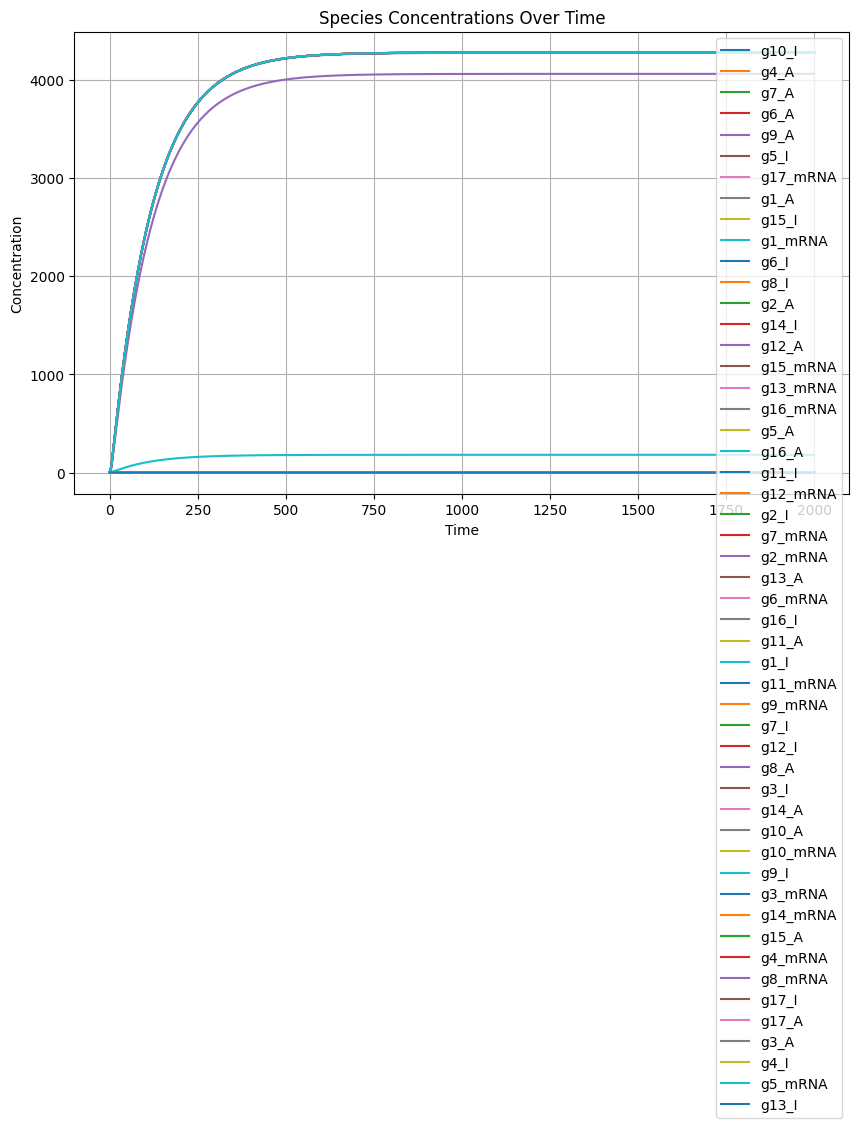

In [20]:
import matplotlib.pyplot as plt

# Number of species
num_species = solution.y.shape[0]

plt.figure(figsize=(10, 6))
for i in range(num_species):
    plt.plot(solution.t, solution.y[i], label=species_list[i])

plt.title('Species Concentrations Over Time')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import cython
from scipy.integrate import solve_ivp
from copy import deepcopy
from tqdm.notebook import tqdm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%load_ext cython

In [4]:
%%cython -a
import numpy as np
cimport numpy as cnp

def calculate_slopes_cython(cnp.ndarray[cnp.float64_t, ndim=2] y_values, cnp.ndarray[cnp.float64_t, ndim=1] t_values):
    """Calculate the slopes of the last 500 points for each species using linear regression in a vectorized manner."""
    cdef int num_species = y_values.shape[0]
    cdef int num_points = 500
    cdef cnp.ndarray[cnp.float64_t, ndim=2] y_segment = y_values[:, -num_points:]  # All species, last 500 points
    cdef cnp.ndarray[cnp.float64_t, ndim=1] t_segment = t_values[-num_points:]  # Last 500 points
    
    cdef cnp.ndarray[cnp.float64_t, ndim=1] slopes = np.empty(num_species)
    cdef double t_mean = np.mean(t_segment)
    cdef double var_t = np.sum((t_segment - t_mean) ** 2)
    cdef double y_mean, cov_yt
    
    cdef int i
    for i in range(num_species):
        y_mean = np.mean(y_segment[i])
        cov_yt = np.sum((y_segment[i] - y_mean) * (t_segment - t_mean))
        slopes[i] = cov_yt / var_t

    return slopes


In [11]:
# Update propensities in the DataFrame using updated parameter values
def update_propensities(reactions_df, params):
    for param, value in params.items():
        if isinstance(value, str):
            value = eval(value.format(**params))
        reactions_df['propensity'] = reactions_df['propensity'].replace(f"{{{param}}}", str(value), regex=True)
    return reactions_df


# Parse reactions to create ODE system
def parse_reactions(reactions_df):
    species = set(reactions_df['species1'].tolist() + reactions_df['species2'].tolist())
    species.discard('_')  # Remove placeholder if used
    def ode_system(t, y):
        dydt = {s: 0 for s in species}
        species_idx = {s: i for i, s in enumerate(species)}
        for idx, row in reactions_df.iterrows():
            local_env = {s: y[species_idx[s]] for s in species}
            reaction_rate = eval(row['propensity'], None, local_env)

            # Convert changes to float, handle both '_' and '-' placeholders
            change1 = float(row['change1']) if row['change1'] not in ('_', '-') else 0
            change2 = float(row['change2']) if row['change2'] not in ('_', '-') else 0

            if row['species1'] not in ('_', '-'):
                dydt[row['species1']] += reaction_rate * change1
            if row['species2'] not in ('_', '-'):
                dydt[row['species2']] += reaction_rate * change2

        return [dydt[s] for s in species]
    return ode_system, list(species)

def normalize_species_name(name):
    return name.replace("-", "_")

In [15]:
def calculate_slopes(y_values, t_values):
    """Calculate the slopes of the last 500 points for each species using linear regression in a vectorized manner."""
    # Extract the relevant segments of y_values and t_values just once
    y_segment = y_values[:, -500:]  # All species, last 500 points
    t_segment = t_values[-500:]     # Last 500 points

    # Calculate the means of y and t
    y_mean = np.mean(y_segment, axis=1)
    t_mean = np.mean(t_segment)

    # Calculate the covariance between t and each y, and the variance of t
    cov_matrix = np.dot(y_segment - y_mean[:, np.newaxis], (t_segment - t_mean))
    var_t = np.dot(t_segment - t_mean, t_segment - t_mean)

    # Slopes
    slopes = cov_matrix / var_t
    return slopes

def process_simulation(row_index, param_dict, original_reactions_df, species_list, initial_conditions):
    reactions_df = deepcopy(original_reactions_df)
    reactions_df = update_propensities(reactions_df, param_dict)
    ode_system, species_list = parse_reactions(reactions_df)
    # print(species_list)
    # Check and print the lengths of species and initial conditions
    
    # initial_conditions = [initial_conditions_dict.get(species, 0) for species in species_list]
    
    # Check again after reassigning initial conditions
    t_span = (0,5000)
    try:
        solution = solve_ivp(ode_system, t_span, initial_conditions, method='RK45', t_eval=np.linspace(0, 5000, 10000))
    except ValueError as e:
        raise(ValueError(f"Failed to solve ODE: {e}"))
    
    slopes = np.array(calculate_slopes_cython(solution.y, solution.t))
        # Check if any slope is greater than 1
    if (slopes > 0.01).any():
        # Plot results for all species if any slope is greater than 1
        tqdm.write(f"Error in row {row_index}")
        num_species = solution.y.shape[0]

        plt.figure(figsize=(10, 6))
        for i in range(num_species):
            if("_mRNA" in species_list[i]):
                plt.plot(solution.t, solution.y[i], label=species_list[i])

        plt.title('Species Concentrations Over Time')
        plt.xlabel('Time')
        plt.ylabel('Concentration')
        plt.legend()
        plt.grid(True)
        plt.show()

# Path to the reactions folder

edges16Number1.csv


  0%|          | 0/500 [00:00<?, ?it/s]

Error in row 1


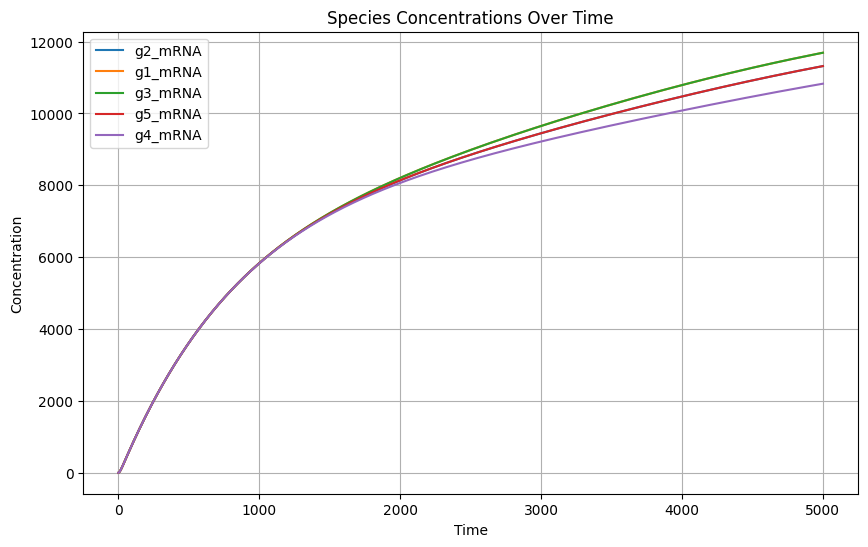

Error in row 48


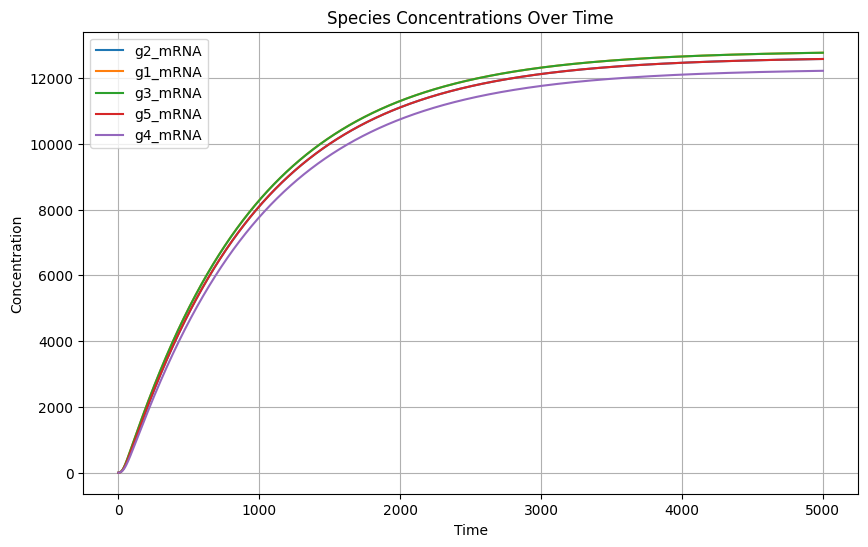

KeyboardInterrupt: 

In [16]:

reactions_folder = '/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/KeerthanaArun/grnInference/grnSimulationSetup/highthroughputData/reactions'
parameter_file = '/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/KeerthanaArun/grnInference/grnSimulationSetup/highthroughputData/parameterSets/logRanges2020Parameters500Seed42.csv'

# Load parameters
params_df = pd.read_csv(parameter_file)

# List all reaction files in the folder
reaction_files = [file for file in os.listdir(reactions_folder) if file.endswith('.csv')]
# initial_conditions_df['species'] = initial_conditions_df['species'].apply(normalize_species_name)
# initial_conditions_dict = initial_conditions_df.set_index('species')['count'].to_dict()
# initial_conditions = [initial_conditions_dict.get(species, 0) for species in species_list]
initial_conditions = [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0]

# Process each reactions file
for reaction_file in reaction_files:
    # Construct full path to the file
    file_path = os.path.join(reactions_folder, reaction_file)
    print(reaction_file)
    # Load reaction data
    reactions_df = pd.read_csv(file_path)
    reactions_df['species1'] = reactions_df['species1'].apply(normalize_species_name)
    reactions_df['species2'] = reactions_df['species2'].apply(normalize_species_name)
    reactions_df['propensity'] = reactions_df['propensity'].apply(normalize_species_name)
    
    species_list = list(set(reactions_df['species1']).union(reactions_df['species2']))
    # Iterate over each parameter set in params_df
    for index, row in tqdm(params_df.iterrows(), total=params_df.shape[0], mininterval=2.0):
        param_dict = row.to_dict()
        param_dict['k'] = "(0.95 * {d} * ({rProd}/{rDeg}))"
        # initial_conditions = [initial_conditions_dict.get(species, 0) for species in species_list]
        process_simulation(index, param_dict, reactions_df, species_list, initial_conditions)

